# Lungs Segmentation Using U-Net

Topics:
  - About Dataset
  - Install and Load Library
  - Data Processing
  - U-Net Architecture
  - Train Model

## About Dataset

--------------------------

### Chest X-ray Dataset for Tuberculosis Segmentation
Chest X-ray Organized Lung Segmentation Masks

------------------------
This dataset consists of 704 chest X-ray images that have been curated from two sources: the Montgomery County Chest X-ray Database (USA) and the Shenzhen Chest X-ray Database (China). The images are used for training and evaluating machine learning models for tuberculosis (TB) detection.

The dataset contains both tuberculosis-positive and normal chest X-rays, along with demographic details such as gender, age, and county of origin. The images are accompanied by lung segmentation masks and clinical metadata, which makes the dataset highly suitable for deep learning applications in medical imaging.

**Link Dataset**: [link](https://www.kaggle.com/datasets/iamtapendu/chest-x-ray-lungs-segmentation/data)


## Install and Load Library

In [5]:
# !pip install visualkeras
# !pip install seaborn

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.utils import Sequence
from tensorflow import keras
from tensorflow.keras.layers import (
    MaxPool2D, Conv2D, Conv2DTranspose, Input, Dropout, Activation,
    BatchNormalization, LeakyReLU, ReLU, concatenate
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

2024-12-21 12:13:09.163568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-21 12:13:09.178905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-21 12:13:09.183320: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-21 12:13:09.194967: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-21 12:13:10.096754: W tensorflow/compiler/tf2

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import os
import warnings
warnings.filterwarnings('ignore')

import cv2
from cv2 import imread,resize

from scipy.ndimage import label, find_objects

from sklearn.model_selection import train_test_split

import visualkeras

## Data Processing

In [4]:
IMG_PATH = '/teamspace/studios/this_studio/Chest-X-Ray/Chest-X-Ray/image/'
MSK_PATH = '/teamspace/studios/this_studio/Chest-X-Ray/Chest-X-Ray/mask/'

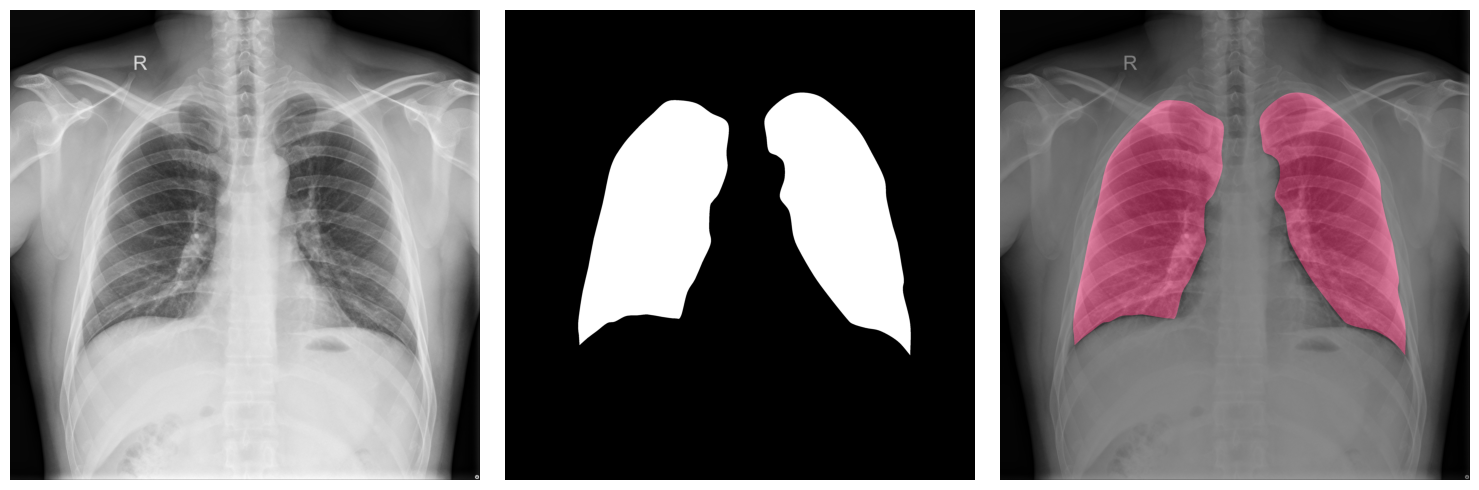

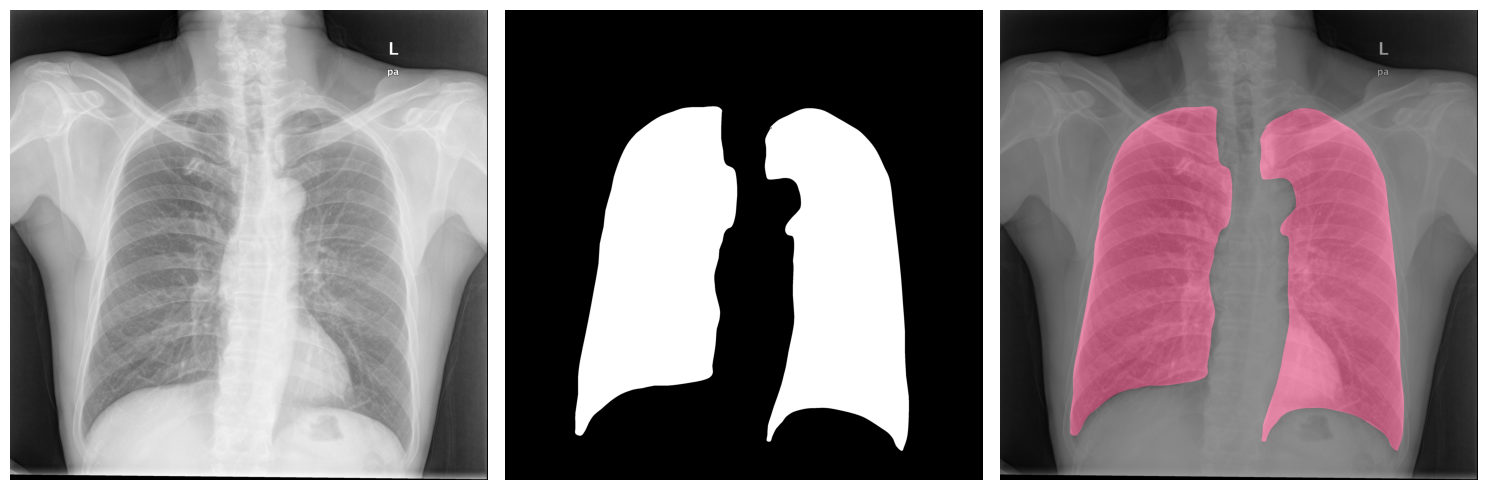

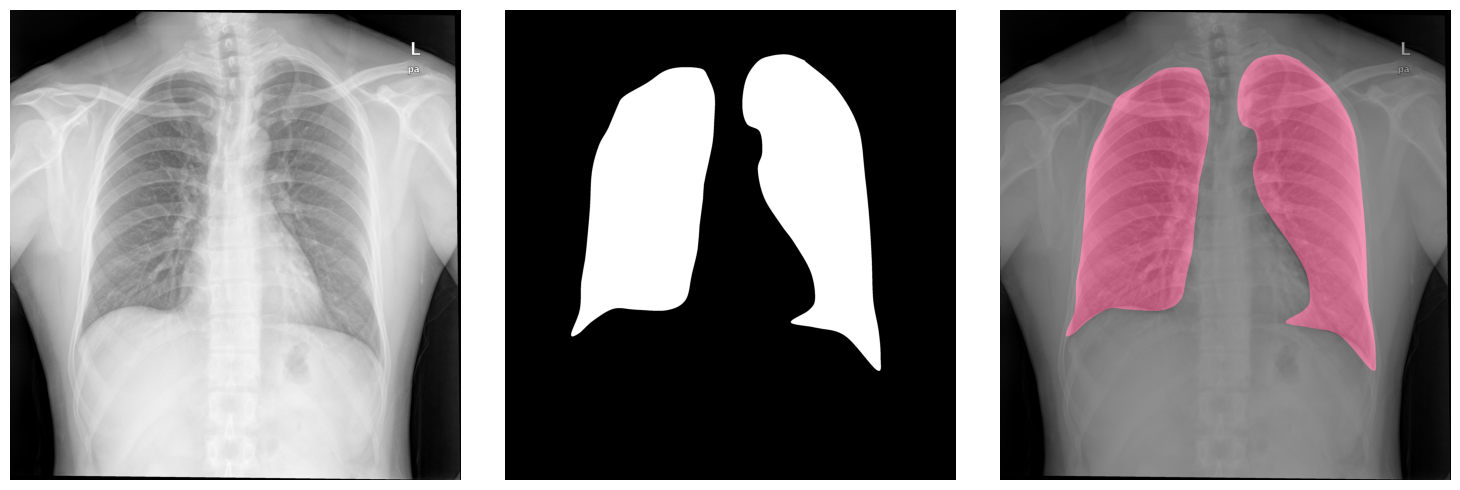

In [13]:
def get_colored_mask(image, mask_image,color = [255,20,100]):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    mask_coord = np.where(mask!=[0,0,0])
    mask[mask_coord[0],mask_coord[1],:]= color
    ret = cv2.addWeighted(image, 0.6, mask, 0.4, 0)
    return ret

filenames = next(os.walk(IMG_PATH))[2][:3]
for file in filenames:
    img = imread(IMG_PATH+file)
    msk = imread(MSK_PATH+file)

    plt.figure(figsize=(15,5))

    plt.subplot(131)
    plt.imshow(img)
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.subplot(132)
    plt.imshow(msk,cmap='binary_r')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.subplot(133)
    plt.imshow(get_colored_mask(img,msk))
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.tight_layout()
    plt.show()


In [5]:
class DataGenerator(keras.utils.PyDataset):
    def __init__(self, img_files, mask_files, batch_size=32, size=(512, 512), seed=1, shuffle=True, **kwargs):

        super().__init__(**kwargs)

        self.img_filenames = img_files
        self.mask_filenames = mask_files

        self.batch_size = batch_size
        self.size = size
        self.seed = seed
        self.shuffle = shuffle

        assert len(self.img_filenames) == len(self.mask_filenames), \
            "The number of images and masks must be the same"

        self.indexes = np.arange(len(self.img_filenames))

        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.img_filenames) / self.batch_size))

    def __getitem__(self, index):

        batch_indices = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []

        for i, idx in enumerate(batch_indices):
            img = imread(IMG_PATH+self.img_filenames[idx],0)
            img = resize(img, self.size)
            img = img / 255.0

            mask = imread(MSK_PATH+self.mask_filenames[idx],0)
            mask = resize(mask, self.size)
            mask = np.expand_dims(mask, axis=-1)
            mask = mask / 255.0
            mask[mask > 0.5] = 1

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):

        if self.shuffle:
            np.random.shuffle(self.indexes)

img_files, msk_files = sorted(os.listdir(IMG_PATH)), sorted(os.listdir(MSK_PATH))


In [6]:
train_img_files, val_img_files, train_msk_files, val_msk_files = train_test_split(
    img_files,msk_files,test_size=0.2,random_state=1
)

train_data = DataGenerator(
    img_files=train_img_files,
    mask_files=train_msk_files,
    batch_size=16,
    size=(512, 512),
    workers=4,
    use_multiprocessing=True
)

val_data = DataGenerator(
    img_files=val_img_files,
    mask_files=val_msk_files,
    batch_size=16,
    size=(512, 512),
    workers=4,
    use_multiprocessing=True
)

## U-Net Architecture
--------------------------------
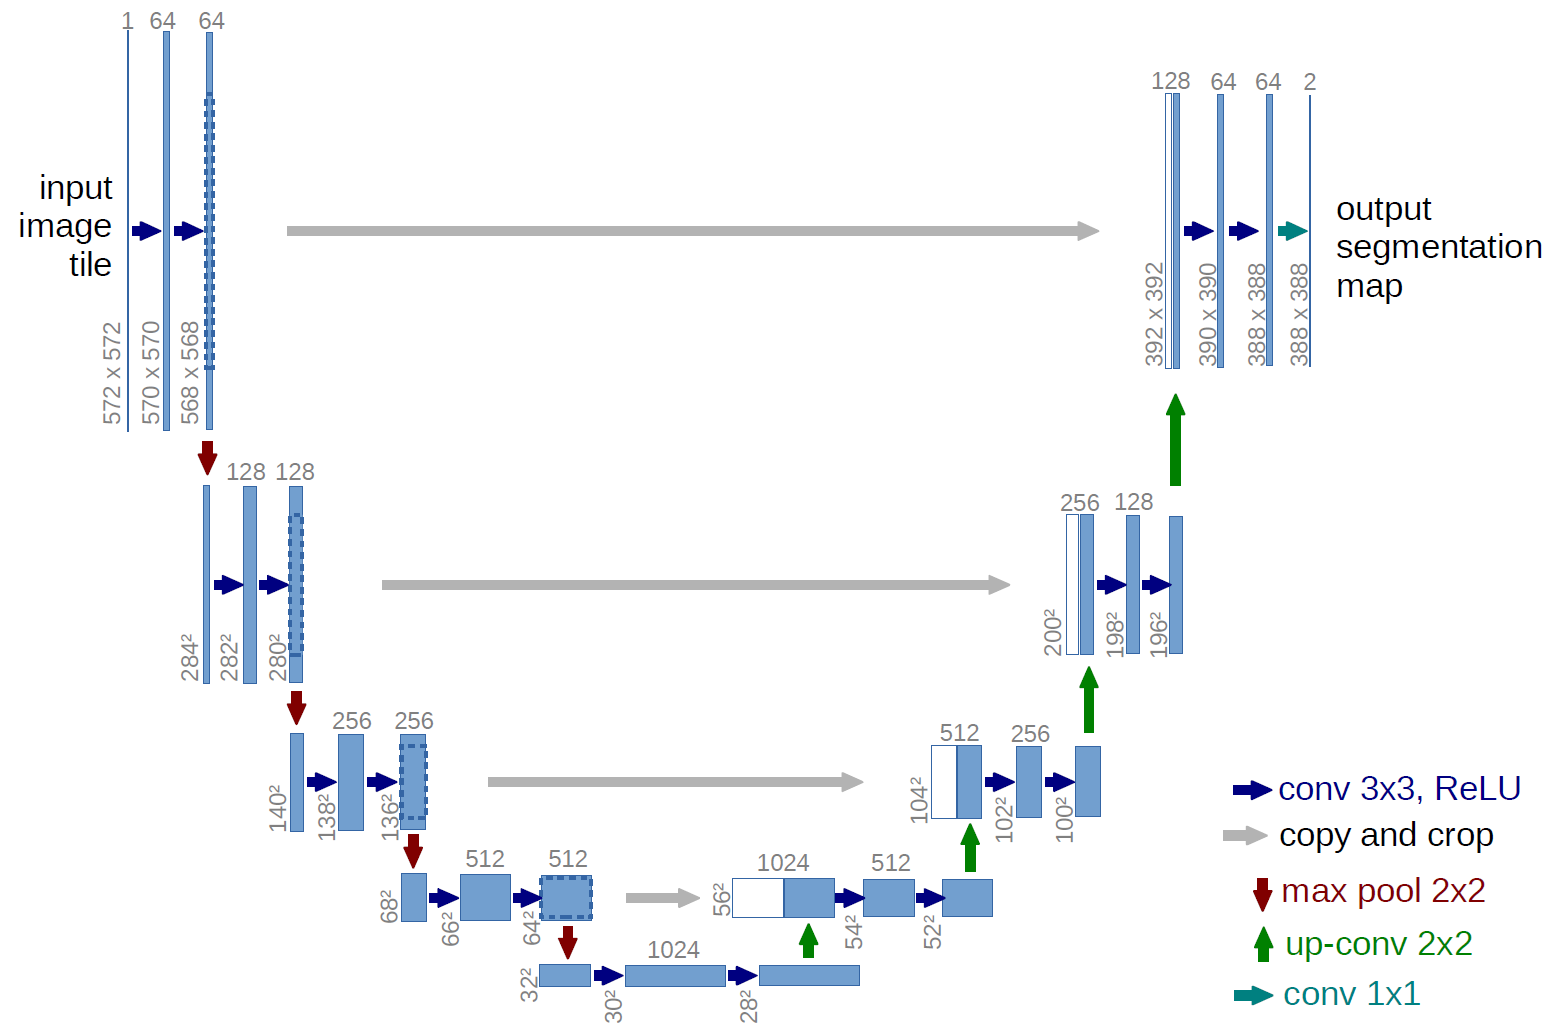



In [7]:
def encode(filter, kernel_size=(3, 3), strides=1, padding='same'):
  encoder = Sequential()
  encoder.add(Conv2D(filter, kernel_size=kernel_size, strides=strides, padding=padding))
  encoder.add(BatchNormalization(axis=3))
  encoder.add(LeakyReLU())
  return encoder

In [8]:
def decode(filter, kernel_size=(3, 3), strides=1, padding='same'):
  decoder = Sequential()
  decoder.add(Conv2DTranspose(filter, kernel_size=kernel_size, strides=strides, padding=padding))
  decoder.add(BatchNormalization(axis=3))
  decoder.add(LeakyReLU())
  return decoder

In [9]:
# inputs
inputs = layers.Input(shape=(512, 512, 1))

# encoder
e1 = encode(64)(inputs)
e2 = encode(64)(e1)
e3 = encode(64)(e2)
pool = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(e3)
e4 = encode(128)(pool)
e5 = encode(128)(e4)
e6 = encode(128)(e5)
pool = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(e6)
e7 = encode(256)(pool)
e8 = encode(256)(e7)
e9 = encode(256)(e8)
pool = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(e9)

# Bottleneck
b1 = encode(512)(pool)
b2 = encode(512)(b1)
b3 = encode(512)(b2)
pool = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(b3)

# decoder
d1 = decode(512, (2, 2), 2)(pool)
merg1 = concatenate([d1, b3])
d2 = encode(512)(merg1)
d3 = encode(512)(d2)
# d4 = encode(512)(d3)
d5 = decode(256, (2, 2), 2)(d3)
merg2 = concatenate([d5, e9])
d6 = encode(256)(merg2)
d7 = encode(256)(d6)
# d8 = encode(256)(d7)
d9 = decode(128, (2, 2), 2)(d7)
merg3 = concatenate([d9, e6])
d10 = encode(128)(merg3)
d11 = encode(128)(d10)
# d12 = encode(128)(d11)
d13 = decode(64, (2, 2), 2)(d11)
merg4 = concatenate([d13, e3])
d14 = encode(64)(merg4)
d15 = encode(64)(d14)

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d15)


model = Model(inputs, outputs)
model.summary()


2024-12-21 12:13:40.857164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43629 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:34:00.0, compute capability: 8.9


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 512, 512,  │        896 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 512, 512,  │     37,184 │ sequential[0][0]  │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 512, 512,  │     37,184 │ sequential_1[0][… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ sequential_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 256, 256,  │     74,368 │ max_pooling2d[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 256, 256,  │    148,096 │ sequential_3[0][… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 256, 256,  │    148,096 │ sequential_4[0][… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ sequential_5[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 128, 128,  │    296,192 │ max_pooling2d_1[… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 128, 128,  │    591,104 │ sequential_6[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 128, 128,  │    591,104 │ sequential_7[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ sequential_8[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 64, 64,    │  1,182,208 │ max_pooling2d_2[… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 64, 64,    │  2,361,856 │ sequential_9[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 64, 64,    │  2,361,856 │ sequential_10[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ sequential_11[0]

 Total params: 18,981,633 (72.41 MB)

 Trainable params: 18,970,113 (72.37 MB)

 Non-trainable params: 11,520 (45.00 KB)

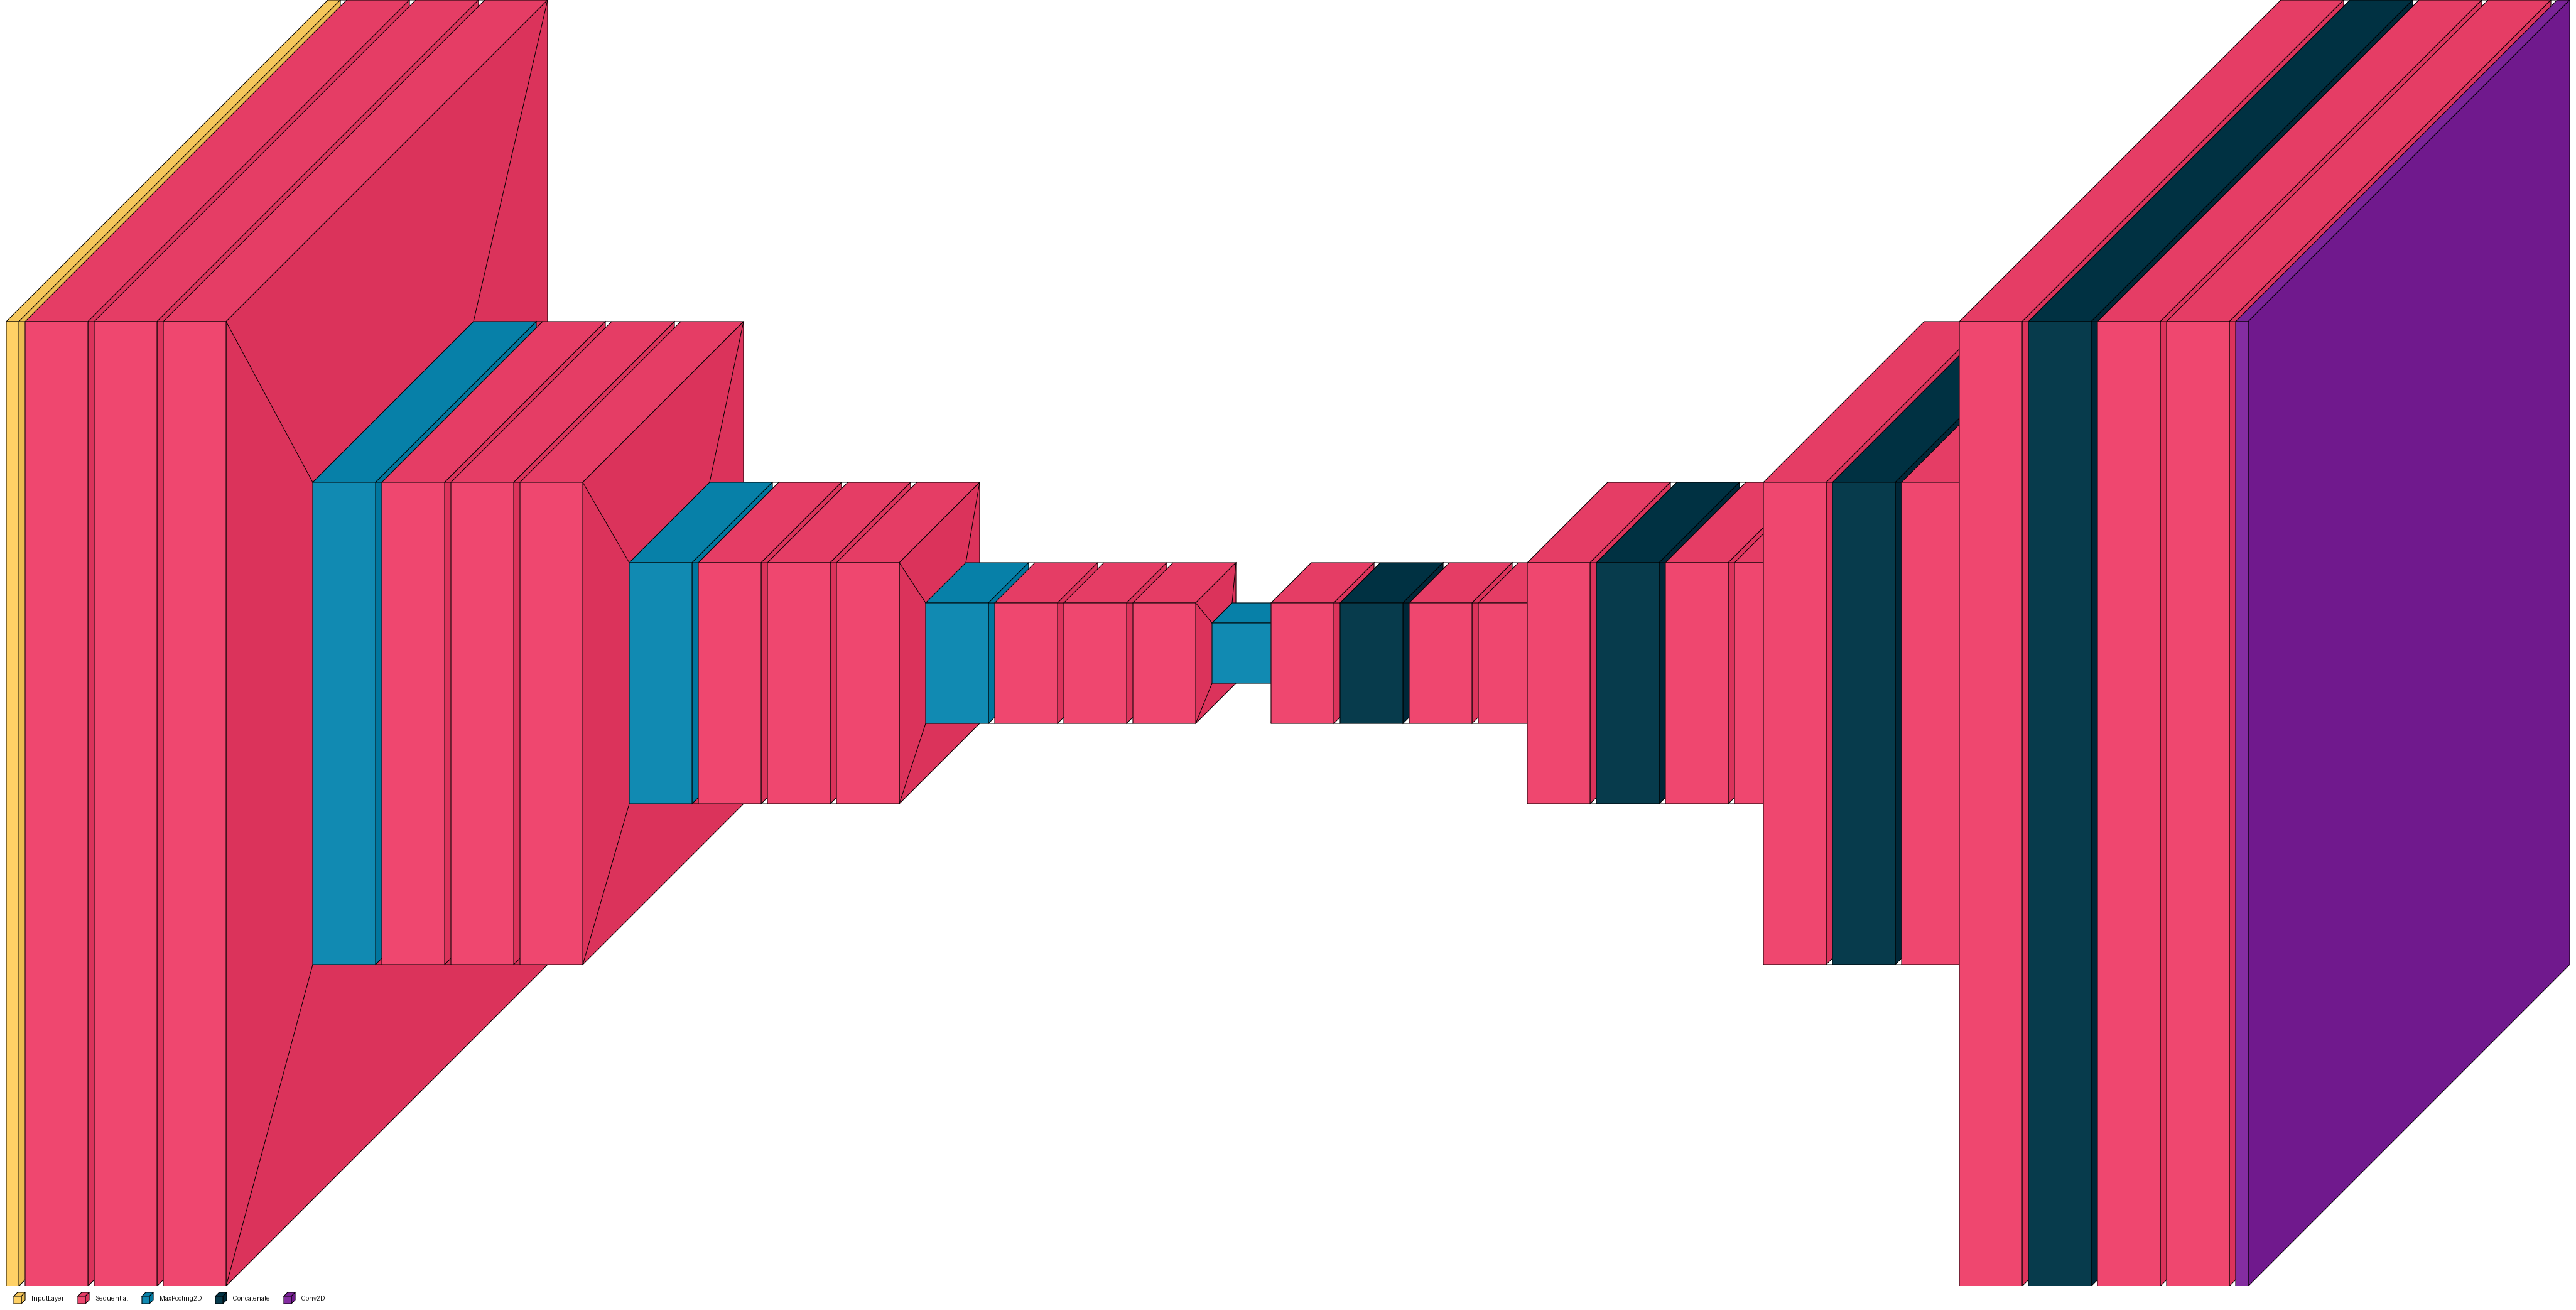

In [74]:
visualkeras.layered_view(model, legend=True, scale_xy=3, scale_z=3, max_z=100)

## Train Model

In [10]:
def jaccard_index(y_true, y_pred, smooth=100):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (total + smooth)


def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',dice_coefficient,jaccard_index])

In [11]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=65,
)

Epoch 1/65


I0000 00:00:1734783247.255732   43153 service.cc:146] XLA service 0x7f3f1c012d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734783247.255767   43153 service.cc:154]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2024-12-21 12:14:07.492802: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-21 12:14:08.490150: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
I0000 00:00:1734783311.058638   43153 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35/35 ━━━━━━━━━━━━━━━━━━━━ 106s 881ms/step - accuracy: 0.7496 - dice_coefficient: 0.5195 - jaccard_index: 0.3540 - loss: 0.5522 - val_accuracy: 0.6384 - val_dice_coefficient: 0.1640 - val_jaccard_index: 0.0903 - val_loss: 267.6628
Epoch 2/65
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 783ms/step - accuracy: 0.8929 - dice_coefficient: 0.6777 - jaccard_index: 0.5137 - loss: 0.2817 - val_accuracy: 0.2486 - val_dice_coefficient: 0.3983 - val_jaccard_index: 0.2488 - val_loss: 252.3272
Epoch 3/65
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 794ms/step - accuracy: 0.9294 - dice_coefficient: 0.7711 - jaccard_index: 0.6286 - loss: 0.1978 - val_accuracy: 0.4027 - val_dice_coefficient: 0.3961 - val_jaccard_index: 0.2475 - val_loss: 56.9085
Epoch 4/65
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 794ms/step - accuracy: 0.9529 - dice_coefficient: 0.8484 - jaccard_index: 0.7370 - loss: 0.1363 - val_accuracy: 0.7495 - val_dice_coefficient: 1.8830e-05 - val_jaccard_index: 1.0431e-04 - val_loss: 2.9324
Epoch 5/65
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s

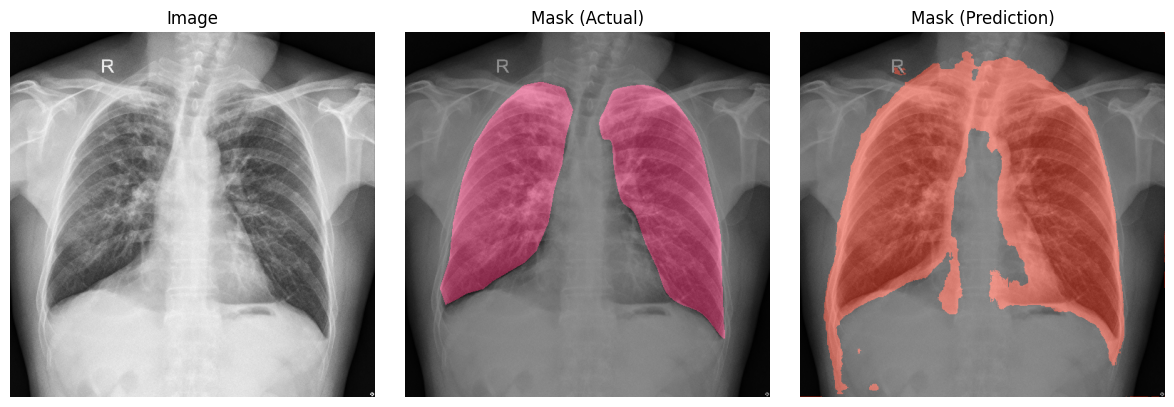

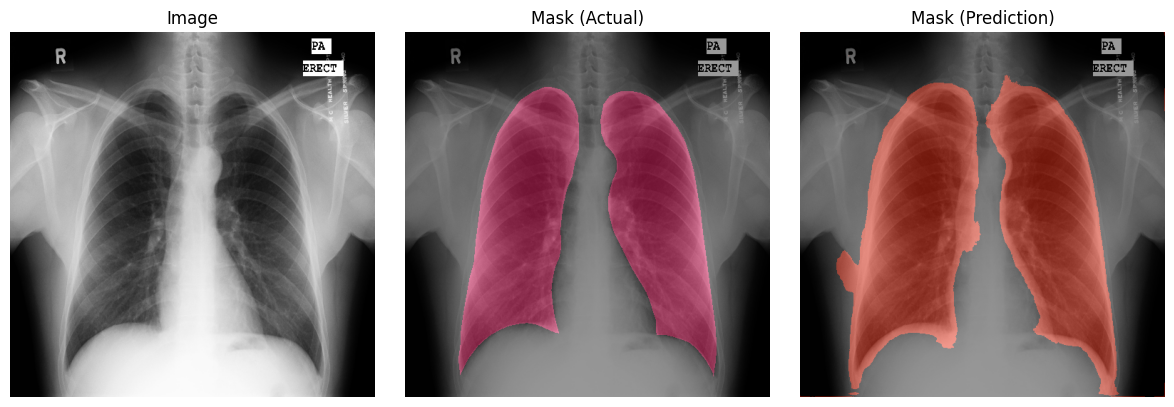

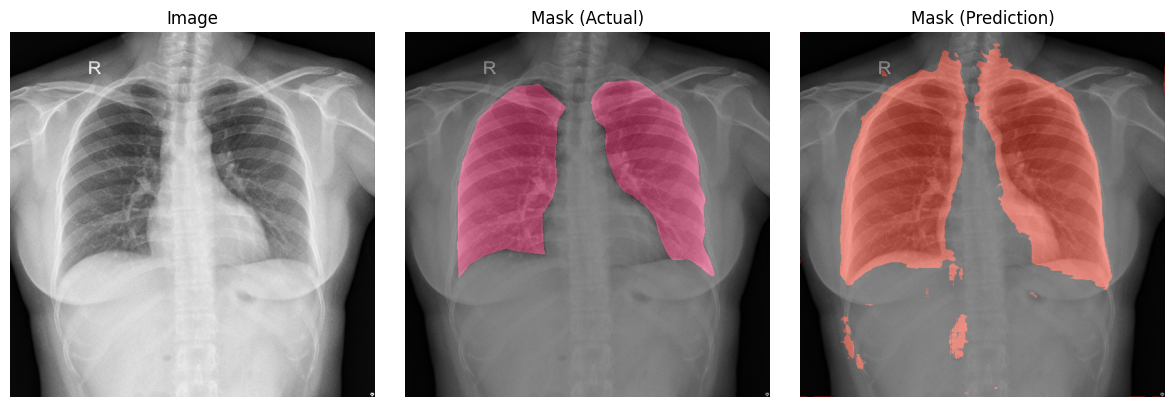

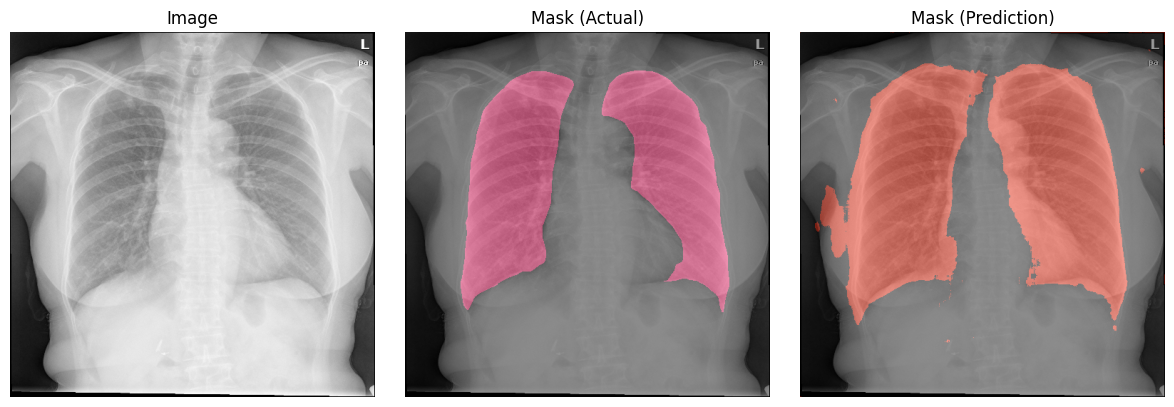

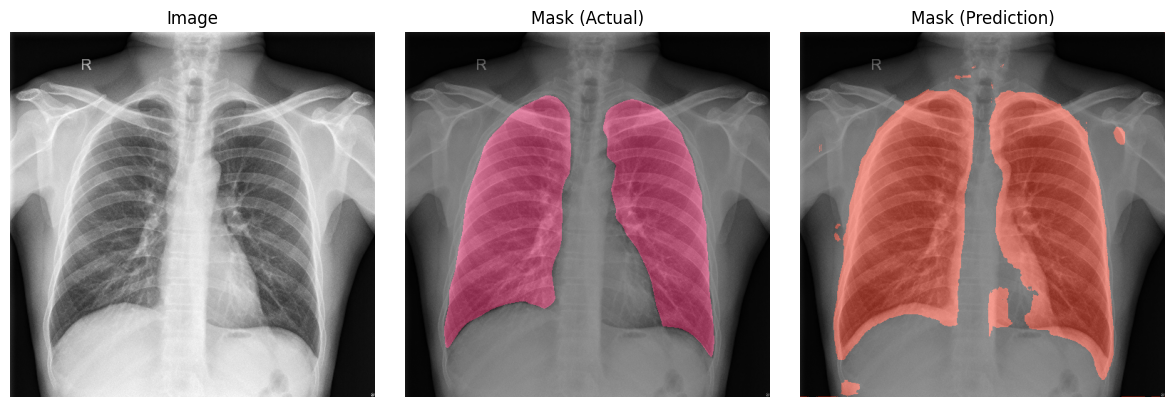

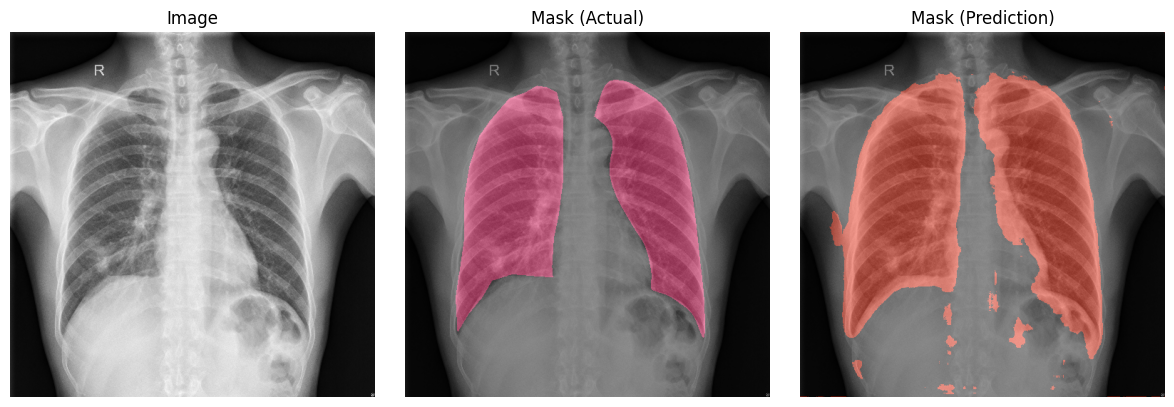

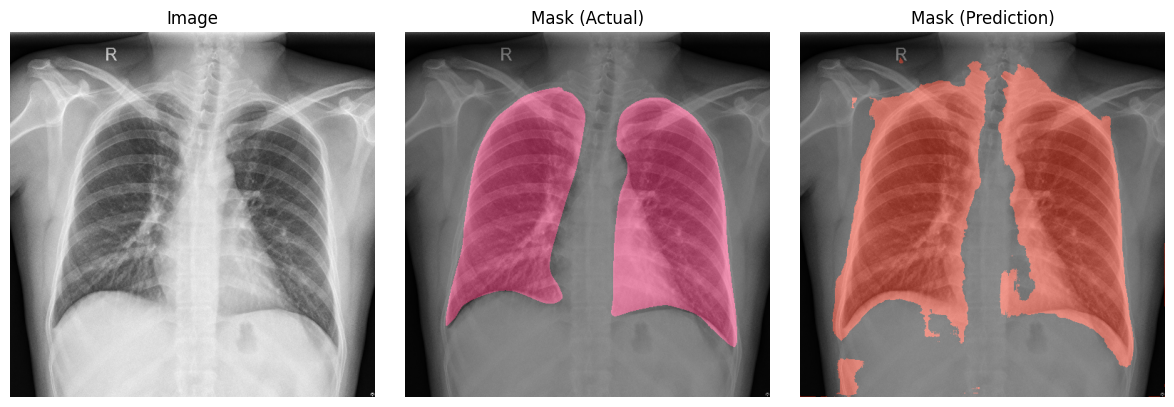

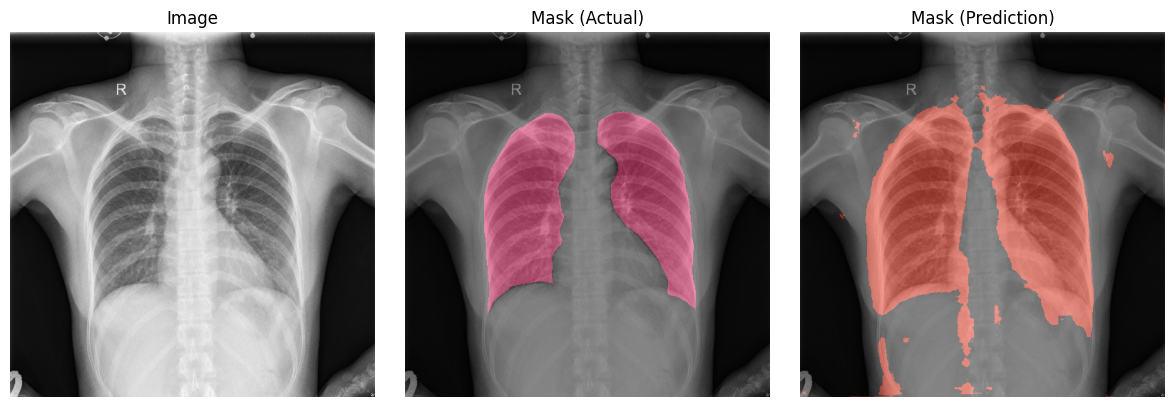

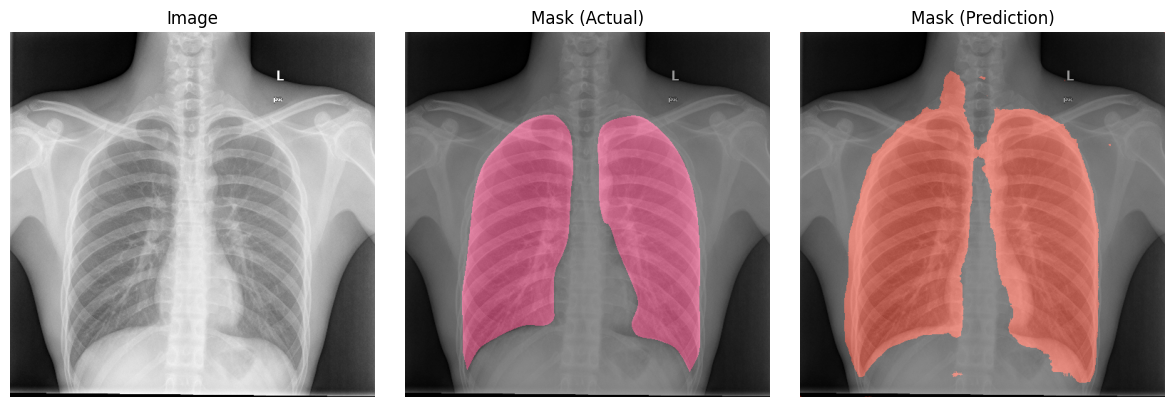

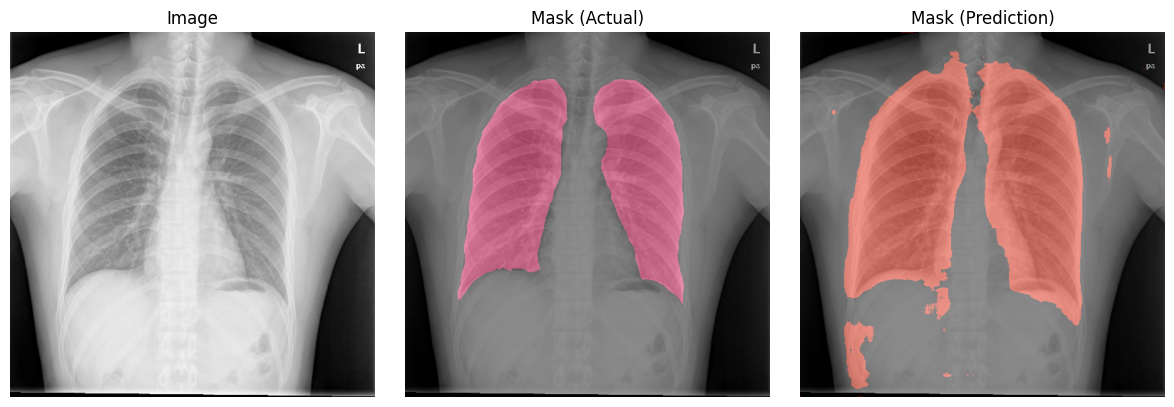

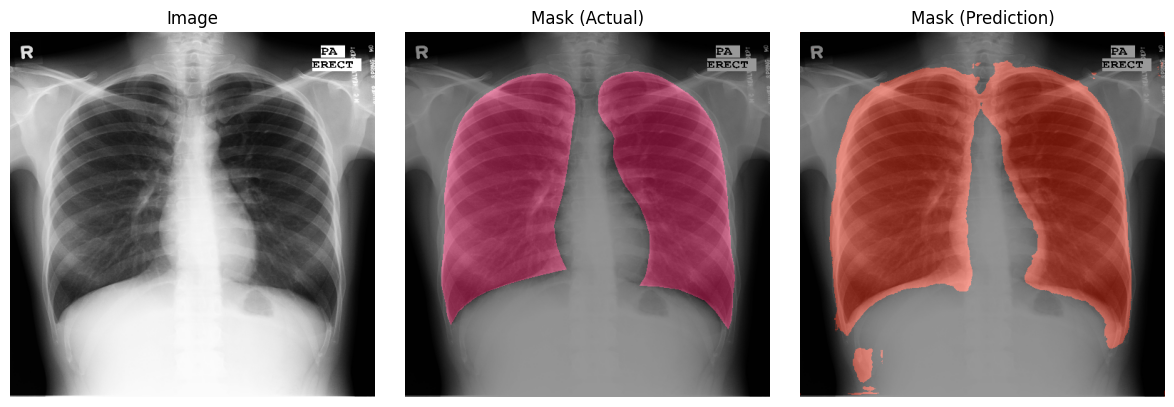

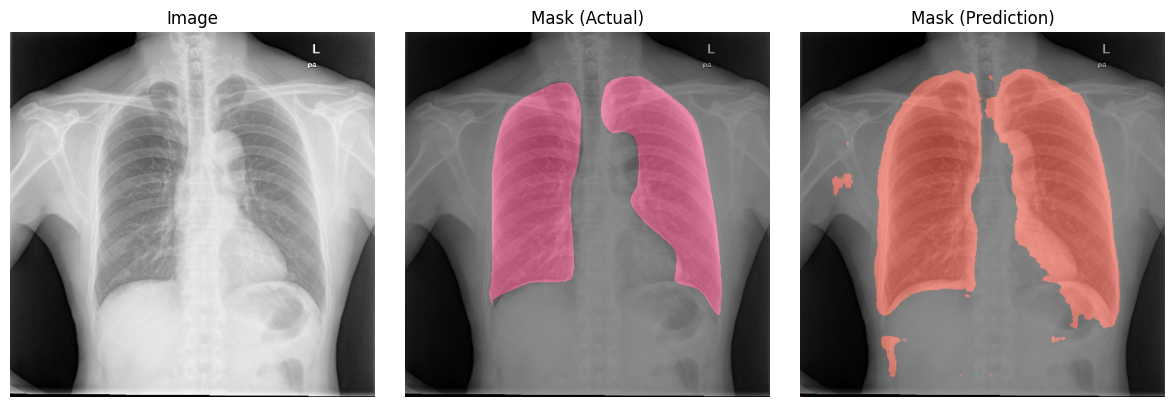

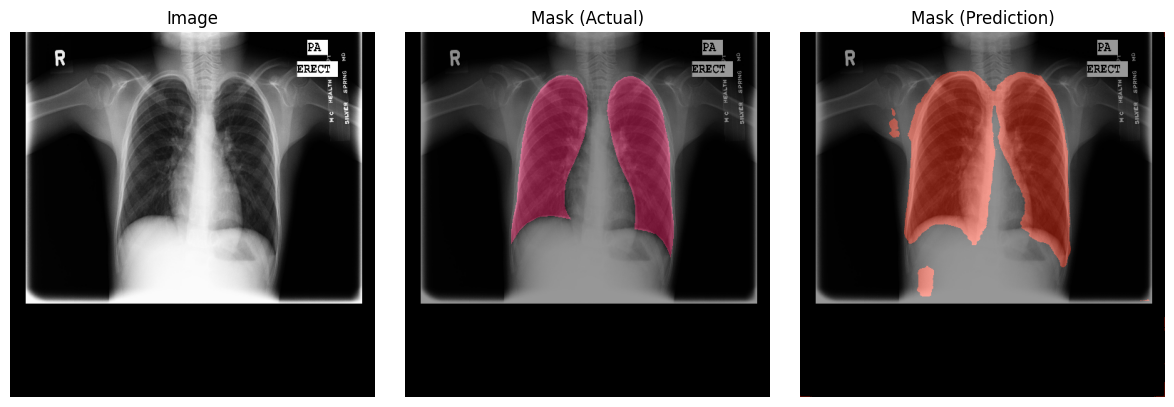

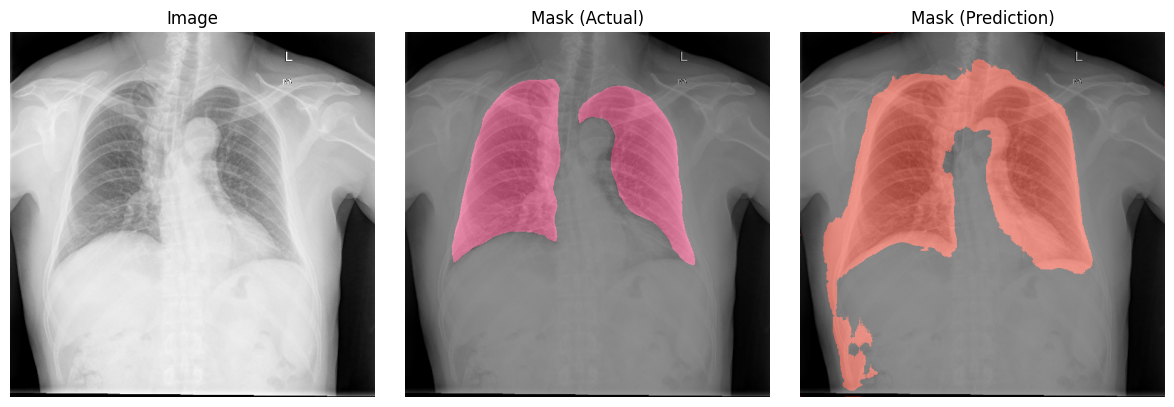

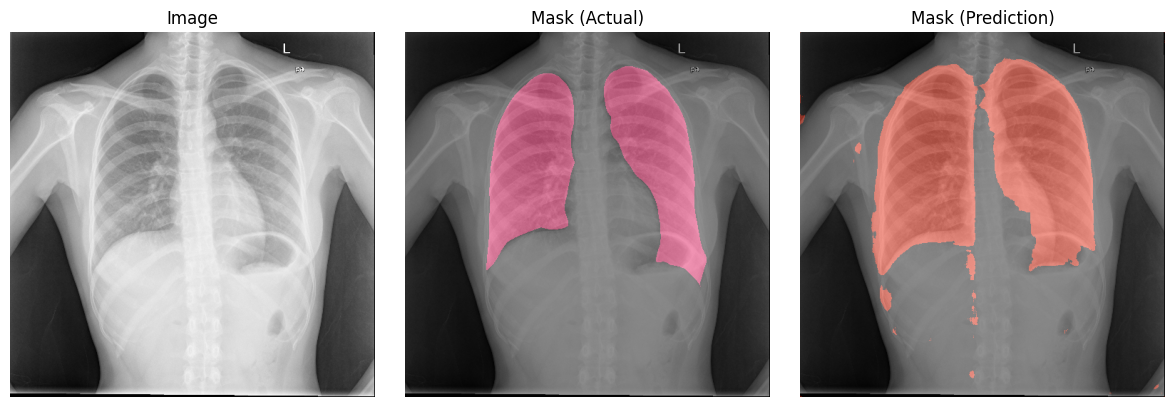

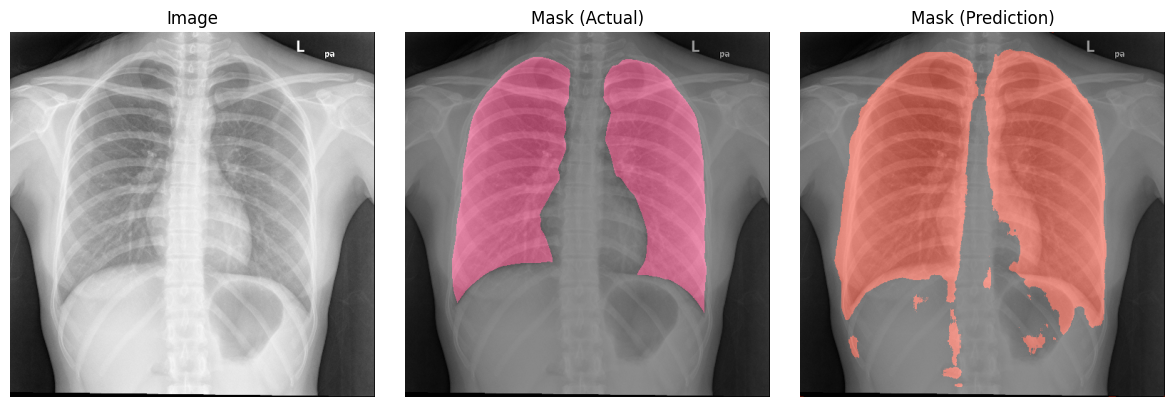

In [14]:
imgs, msks  = val_data.__getitem__(1)

for img,msk in zip(imgs,msks):
    img = np.expand_dims(img, axis=0)
    pred = (np.squeeze(model.predict(img,verbose=0))*255).astype(np.uint8)
    img = (np.squeeze(img) * 255).astype(np.uint8)
    msk = (msk*255).astype(np.uint8)

    img= cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    msk = cv2.cvtColor(msk, cv2.COLOR_GRAY2RGB)
    pred = cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB)

    plt.figure(figsize=(12,4))

    plt.subplot(131)
    plt.imshow(img)
    plt.title('Image')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.subplot(132)
    plt.imshow(get_colored_mask(img,msk))
    plt.title('Mask (Actual)')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.subplot(133)
    plt.imshow(get_colored_mask(img,pred,color = [255,30,0]))
    plt.title('Mask (Prediction)')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.tight_layout()
    plt.show()

In [ ]:
# save model
model.save('LungsSegmentationUsingU-Net.h5')